## CNN (Convolution Neural Network)

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import torch as tc

### Example : MNIST Data Set

Define Hyper-parameters

In [2]:
device = tc.device('cuda' if tc.cuda.is_available() else 'mps:0')
print(f'device : {device}')

num_classes = 10 # total 10 classes
in_channel = 1 # white/black use 1 channel

#Set a hyperparameter
batch_size = 10 # 배치사이즈를 높게 잡으면 GPU연산을 소모하기 때문에 16개 이하로 한다
max_pool_kernel = 2 # pooling layer
learning_rate = 0.0001 # epoch마다 learning rate 바꿀수도 있다
num_epochs = 3

device : mps:0


### Import Data and Module

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
train_data = torchvision.datasets.MNIST(root = './datasets',
                                        train = True,
                                        transform = transforms.ToTensor(),
                                        download = True)
test_data = torchvision.datasets.MNIST(root = './datasets',
                                       train = False,
                                       transform = transforms.ToTensor())

### Check Images

In [5]:
print(f"Total train data: {len(train_data)}")
print(f"Total test data: {len(test_data)}")
print("*"*20)
print("Check data shape")
print("Data shape:",test_data[0][0].shape)
print("Data label:",test_data[0][1]) # answer가 아닌 label인 이유 : 오류가 있을수도 있기 떄문이다

Total train data: 60000
Total test data: 10000
********************
Check data shape
Data shape: torch.Size([1, 28, 28])
Data label: 7


In [6]:
print(train_data[0][0].shape, train_data[0][1])

torch.Size([1, 28, 28]) 5


- 데이터는 float형태로 저장되어 있다
- 첫번째 index에는 데이터가, 두 번째 index에는 label이 붙어 있다

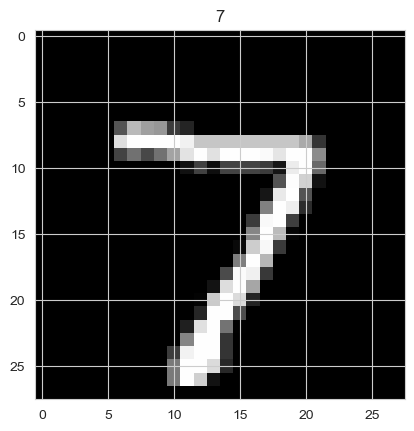

data shape: torch.Size([1, 28, 28])


In [7]:
plt.imshow(test_data[0][0].reshape(28,28), cmap = 'gray')
plt.title(test_data[0][1]) # label
plt.show()
print("data shape:",test_data[0][0].shape)

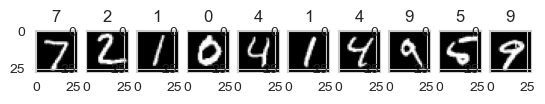

In [8]:
%matplotlib inline
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(test_data[i][0].reshape(28,28), cmap = 'gray')
    plt.title(test_data[i][1])

### Define Dataloader

In [9]:
import torch
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = True)

- 전체 데이터가 몇 개인지는 알 수 없고, 불러오는 개념. generator 생각하면 편하다

### Define Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary # optional, to see model's summary

In [11]:
class ConvNet(nn.Module) :
    def __init__(self, num_classes = 10) : #data를 받아 초깃값 지정
        super(ConvNet, self).__init__()
        #입력 : (1 * 28 * 28)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channel, 16, 5, stride = 1, padding = 2), # stride를 두 개로 하면 이미지가 너무 확 줄어든다
            #(16 * 28 * 28)로 convolution
            nn.BatchNorm2d(16), # 0에서 1 사이로 정규화
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel) # (16 * 14 * 14) 사이즈가 된다
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, stride = 1, padding = 2), # (32 * 14 * 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel) # (32 * 7  * 7)
        )
        
        #troch에서 Linear 는 Keras에서의 Danse와 같다
        self.fc1 = nn.Linear(32 * 7 * 7, 120) # 두 번째 인자는 아무거나 넣어도 된다. 앞보다 더 커져도 상관없다
        self.fc2 = nn.Linear(120, 10) # 대신, 마지막에 분류하고 싶은 수보다 더 큰 수를 넣어야 한다
        
    def forward(self, x) :
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1) # (1, 32*7*7)로 입력된다. 즉, 1D tensor로 vectorization
        x = self.fc1(x)
        x = F.relu(x) # 정규화 필요
        x = self.fc2(x)
        x = F.softmax(x, dim = 1) # 분류에서는 softmax를 사용한다.
        # CrossEntropy를 사용할 때라면, softmax를 사용하면 안 된다.
        
        return x

In [12]:
model = ConvNet(num_classes).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
total_step = len(train_loader)
loss_list = []

# Train
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Assign Tensors to Configured Device
        images = images.to(device)
        labels = labels.to(device)

        # Forward Propagation
        outputs = model(images)

        # Get Loss, Compute Gradient, Update Parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append loss to plot graph
        loss_list.append(loss.detach().cpu().numpy())

        # Print Loss for Tracking Training
        if (i+1) % 2000 == 0: # 2000번에 한 번씩 결과를 출력한다
            acc = 0
            test_image, test_label = next(iter(test_loader))
            _, test_predicted = torch.max(model(test_image.to(device)).data, 1) 
            # torch.max() : 확률이 제일 높은 것을 들고 오게 한다

            for (pred, ans) in zip(test_predicted, test_label):
                if pred == ans:
                    acc += 1 # accuracy : 10개 중 맞는것을 집어넣는다
            acc = acc / len(test_predicted)

            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.1f}%'.format(epoch+1,num_epochs, 
                                                                                        i+1, total_step, 
                                                                                        loss.item(), acc*100))
            print('Testing data: [Predicted: {} / Real: {}]'.format(test_predicted, test_label))

    if epoch+1 == num_epochs:
        torch.save(model.state_dict(), 'model.pth') # torch.save를 통해서 모델을 저장할 수 있다.
        # torch.load('model.pth')
    else:
        torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

Epoch [1/3], Step [2000/6000], Loss: 1.4964, Accuracy: 100.0%
Testing data: [Predicted: tensor([3, 0, 2, 1, 8, 2, 3, 8, 4, 8], device='mps:0') / Real: tensor([3, 0, 2, 1, 8, 2, 3, 8, 4, 8])]
Epoch [1/3], Step [4000/6000], Loss: 1.4840, Accuracy: 100.0%
Testing data: [Predicted: tensor([0, 8, 2, 0, 6, 4, 8, 4, 4, 6], device='mps:0') / Real: tensor([0, 8, 2, 0, 6, 4, 8, 4, 4, 6])]
Epoch [1/3], Step [6000/6000], Loss: 1.5419, Accuracy: 100.0%
Testing data: [Predicted: tensor([9, 7, 7, 2, 6, 4, 1, 2, 6, 4], device='mps:0') / Real: tensor([9, 7, 7, 2, 6, 4, 1, 2, 6, 4])]
Epoch [2/3], Step [2000/6000], Loss: 1.4699, Accuracy: 100.0%
Testing data: [Predicted: tensor([9, 0, 3, 0, 1, 8, 4, 5, 2, 3], device='mps:0') / Real: tensor([9, 0, 3, 0, 1, 8, 4, 5, 2, 3])]
Epoch [2/3], Step [4000/6000], Loss: 1.4821, Accuracy: 100.0%
Testing data: [Predicted: tensor([0, 2, 9, 0, 1, 1, 3, 5, 3, 9], device='mps:0') / Real: tensor([0, 2, 9, 0, 1, 1, 3, 5, 3, 9])]
Epoch [2/3], Step [6000/6000], Loss: 1.4620, 

In [15]:
#for i, (images, labels) in enumerate(train_loader):
    #if i == 0 :
        #outputs = model(images)
    #else:
        #break

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [16]:
# cf) see network form
print(model)

# cf) check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
    print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
                       model summary                        
layer1.0.weight                  torch.Size([16, 1, 5, 5])   
layer1.0.bias                         torch.Size([16])       
layer1.1.weight                       torch.Size([16])       
layer1.1.bias                      

- Model Parameter 개수 세기 (무조건 시험에 나옴)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train / Test

In [18]:
num_epochs = 3

- torch.save를 통해서, 모델을 저장한다. 차후 과제 제출은 이를 이용하니 유의하도록 한다.
- Jupyter Notebook이 아닌 코랩에서는 폴더에 저장된다.

In [19]:
# Test after training is done
model.eval() # Set model as evaluation mode (instead of mini-batch mean/var, batchnorm is used)
with torch.no_grad(): # auto_grad off
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images {}%'.format(len(test_loader)*batch_size, 
                                                                     100*correct/total))

Accuracy of the network on the 10000 test images 98.5%


model.train( ) vs. model.eval( )
- model.eval( ) : evaluation mode로 만든다.
- model.train( ) : 

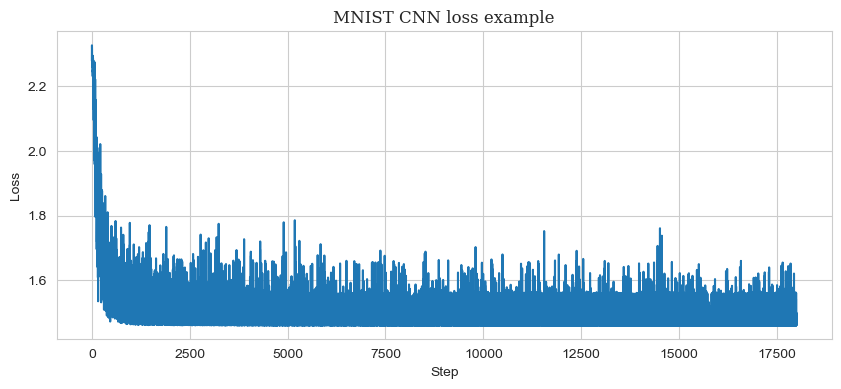

In [21]:
plt.figure(figsize = (10,4))
plt.plot(loss_list)
plt.title("MNIST CNN loss example", fontsize = 12, fontfamily = 'Serif')
plt.ylabel('Loss', fontsize = 10)
plt.xlabel('Step', fontsize = 10)
plt.show() # cross entropy는 1.42정도가 최솟값이라고 생각하면 된다